In [1]:
import seaborn as sn
from imblearn.over_sampling import SMOTE, SMOTENC 
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, multilabel_confusion_matrix, precision_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
from torch import Tensor
from torch.nn import Linear, ReLU, Sigmoid, Module, BCELoss, BCEWithLogitsLoss
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pandas import DataFrame
import xlsxwriter
import time

seed_value = 7
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import torch
torch.manual_seed(seed_value)

In [2]:
Training_Data = pd.ExcelFile("Labels.xlsx") #Training Data already pre-scaled to the IBIS Data set
data = Training_Data.parse(Training_Data.sheet_names[4])
label_data = Training_Data.parse(Training_Data.sheet_names[0])
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['Case','Visit','MATCH','INDEX','ASD+','ASD-','Gender'], axis=1)
data_features = data_features.dropna()
data_features = data_features.drop(['Final Label'], axis=1)
labels = label_data.loc[:, label_data.columns]
labels = labels.drop(['CASE','MATCH','INDEX','ASD+','ASD-'], axis=1)
labels = labels.dropna()
print(data_features.shape)
print(labels.shape)

print(data_features)

(325, 152)
(325, 1)
          ROI01       ROI02       ROI03       ROI04       ROI05       ROI06  \
0    165.815887  358.347351  495.168182  509.735504  232.845993  383.652130   
1    300.181702  462.752716  464.555298  544.092529  317.463257  528.835144   
2    288.945465  671.623840  425.262726  551.006409  286.384033  567.243408   
3    284.080505  401.243591  390.357941  432.806061  413.813049  635.051575   
4    258.001892  423.618713  522.596924  370.944885  367.616455  408.566254   
..          ...         ...         ...         ...         ...         ...   
320  225.355286  388.635345  541.641479  405.124451  296.338837  708.989685   
321  241.952530  646.202332  518.838318  766.203796  307.633575  507.180695   
322  209.272415  438.897919  427.852509  378.745667  204.034790  499.845642   
323  239.067444  611.642700  499.945374  312.045197  387.927032  466.336151   
324  251.201065  675.960510  467.639465  488.050262  265.667114  571.125305   

          ROI07       ROI08    

In [3]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_features)

scaled_data.shape
labels.shape

X_train, X_test, Y_train, Y_test = train_test_split(scaled_data, labels, test_size=0.10, random_state=seed_value)
sm = SMOTENC([150],sampling_strategy = 'minority', random_state = seed_value, k_neighbors=2)
tl = TomekLinks(sampling_strategy = 'majority')


resample = SMOTETomek(smote=sm,tomek=tl,random_state=seed_value)
#Version below works the exact same apparently. Will just pass the old smote object.
#resample = SMOTETomek(smote=SMOTENC([297],sampling_strategy='minority'),tomek=TomekLinks(sampling_strategy='majority'),random_state=seed_value)



#Imblearn has other SMOTE variants to look into.
#ADASYN - creates synthetic data according to the data density. 
#The synthetic data generation would inversely proportional to the density of the minority class. It means more synthetic data are created in regions of the feature space where the density of minority examples is low, and fewer or none where the density is high.
#In simpler terms, in an area where the minority class is less dense, the synthetic data are created more. Otherwise, the synthetic data is not made so much.

#SMOTENC - Denote which features are categorical, and SMOTE would resample the categorical data instead of creating synthetic data.

#Borderline SMOTE
#K SMOTE

#Should increase testing size. Play with testing/training split.
#X_train_smoted, Y_train_smoted = sm.fit_sample(X_train, Y_train) #Only smote the training set.
#X_undersampled, Y_undersampled = tl.fit_resample(X_train, Y_train)
X_resampled, Y_resampled = resample.fit_sample(X_train,Y_train)

#print(X_train_smoted.shape)
#print(Y_train_smoted.shape)
#print(X_undersampled.shape)
#print(Y_undersampled.shape)
print(X_resampled.shape)
print(Y_resampled.shape)
print(X_test.shape)

(484, 152)
(484, 1)
(33, 152)


In [4]:
#Y_train_smoted

In [5]:
#Y_undersampled

In [6]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
#print(X_train_smoted)

In [7]:
X_resampled.shape

(484, 152)

In [8]:
#Some hyperparameters
#D_in is input dimension; H is hidden dimension; D_out is output dimension. 

#Best: 0.674222 using {'batch_size': 35, 'dropout': 0.3, 'epochs': 25, 'layer1_size': 90, 'layer2_size': 35}
D_in, H1, H2, D_out = 152, 90, 35, 1
EPOCHS = 64
BATCH_SIZE = 35
LEARNING_RATE = 0.01
DROPOUT_RATE = 0.15

## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data): #used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)

#A dataloader is then used on this dataset class to read the data in batches.
train_data = trainData(torch.FloatTensor(X_resampled), 
                       torch.FloatTensor(Y_resampled.values))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data): ##used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)
    
#A dataloader is then used on this dataset class to read the data in batches.
test_data = testData(torch.FloatTensor(X_test))

#Initialize DataLoaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=33) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

In [9]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 298.
        self.layer_1 = nn.Linear(D_in, H1) #298 -> 100
        self.layer_2 = nn.Linear(H1, H2) #100 -> 15
        self.layer_out = nn.Linear(H2, D_out) #15 -> 1
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=DROPOUT_RATE)
        #self.batchnorm1 = nn.BatchNorm1d(100)
        #self.batchnorm2 = nn.BatchNorm1d(15)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs)) #ReLU on the 298?
        #x = self.batchnorm1(x) #Normalize the 100
        x = self.dropout(x) #Dropout 15%
        x = self.relu(self.layer_2(x)) #ReLU on the 100?
        #x = self.batchnorm2(x) #Normalize the 15
        x = self.layer_out(x) #1
        
        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#Should use the CPU since I don't have a GPU.

cpu


In [10]:
#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model = binaryClassification()
model.to(device)
print(model)
weights = torch.FloatTensor([5]) #Class weights?
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=152, out_features=90, bias=True)
  (layer_2): Linear(in_features=90, out_features=35, bias=True)
  (layer_out): Linear(in_features=35, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.15, inplace=False)
)


In [11]:
#Function to define accuracy. Should look to see if there is a prebuilt that I can use from sci-kit learn or something.
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [12]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc = []
train_acc = []
train_loss = []
val_loss = []

model.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc.append(epoch_acc/len(train_loader))
    train_loss.append(epoch_loss/len(train_loader))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    #Validation metrics here
    model.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=33)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(Y_test.values))
            val_loss.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(Y_test.values), y_pred_list)
    ppv = precision_score(Y_test, y_pred_list, average=None)
    recall = recall_score(Y_test, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc.append(accuracy*100)
    model.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.41281 | Acc: 49.857
Validation Accuracy |  9.090909090909092  PPV |  [0.         0.09090909]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.30152 | Acc: 49.714
Validation Accuracy |  9.090909090909092  PPV |  [0.         0.09090909]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.28442 | Acc: 49.929
Validation Accuracy |  9.090909090909092  PPV |  [0.         0.09090909]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.22436 | Acc: 50.143
Validation Accuracy |  9.090909090909092  PPV |  [0.         0.09090909]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.11978 | Acc: 50.286
Validation Accuracy |  9.090909090909092  PPV |  [0.         0.09090909]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 006: | Loss: 1.02582 | Acc: 55.786
Validation Accuracy |  42.42424242424242  PPV |  [1.         0.13636364]  Recall |  [0.36666667 1.        ]
Training Epoch 007: | Loss: 0.84008 | Acc: 68.286
Validation Accuracy |  63.63636363636363  PPV |  [0.90909091 0.09090909]  Recall |  [0.66666667 0.33333333]
Training Epoch 008: | Loss: 0.84704 | Acc: 74.929
Validation Accuracy |  36.36363636363637  PPV |  [0.90909091 0.09090909]  Recall |  [0.33333333 0.66666667]
Training Epoch 009: | Loss: 0.83745 | Acc: 73.714
Validation Accuracy |  21.21212121212121  PPV |  [1.         0.10344828]  Recall |  [0.13333333 1.        ]
Training Epoch 010: | Loss: 0.70257 | Acc: 78.286
Validation Accuracy |  60.60606060606061  PPV |  [0.94736842 0.14285714]  Recall |  [0.6        0.66666667]
Training Epoch 011: | Loss: 0.58991 | Acc: 83.500
Validation Accuracy |  39.39393939393939  PPV |  [0.91666667 0.0952381 ]  Recall |  [0.36666667 0.66666667]
Training Epoch 012: | Loss: 0.56730 | Acc: 83.643
Va

Training Epoch 059: | Loss: 0.42172 | Acc: 90.929
Validation Accuracy |  75.75757575757575  PPV |  [0.92307692 0.14285714]  Recall |  [0.8        0.33333333]
Training Epoch 060: | Loss: 0.35037 | Acc: 93.143
Validation Accuracy |  78.78787878787878  PPV |  [0.96 0.25]  Recall |  [0.8        0.66666667]
Training Epoch 061: | Loss: 0.33083 | Acc: 91.143
Validation Accuracy |  63.63636363636363  PPV |  [0.95       0.15384615]  Recall |  [0.63333333 0.66666667]
Training Epoch 062: | Loss: 0.47557 | Acc: 90.143
Validation Accuracy |  63.63636363636363  PPV |  [0.95       0.15384615]  Recall |  [0.63333333 0.66666667]
Training Epoch 063: | Loss: 0.51556 | Acc: 87.643
Validation Accuracy |  72.72727272727273  PPV |  [0.95652174 0.2       ]  Recall |  [0.73333333 0.66666667]
Training Epoch 064: | Loss: 0.66180 | Acc: 86.714
Validation Accuracy |  75.75757575757575  PPV |  [0.95833333 0.22222222]  Recall |  [0.76666667 0.66666667]


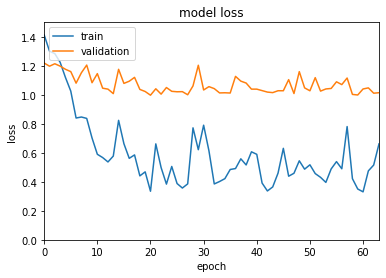

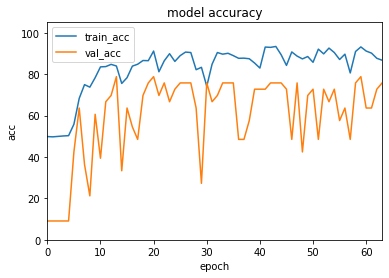

In [13]:
#Plotting loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

Validation Accuracy |  75.75757575757575  PPV |  [0.95833333 0.22222222]  Recall |  [0.76666667 0.66666667]


<AxesSubplot:>

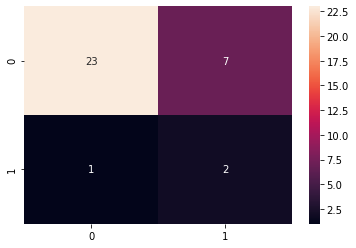

In [14]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data, batch_size=1)
model.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(Y_test, y_pred_list)
ppv = precision_score(Y_test, y_pred_list, average=None)
recall = recall_score(Y_test, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(Y_test, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

In [15]:
print(classification_report(Y_test, y_pred_list))

              precision    recall  f1-score   support

         0.0       0.96      0.77      0.85        30
         1.0       0.22      0.67      0.33         3

    accuracy                           0.76        33
   macro avg       0.59      0.72      0.59        33
weighted avg       0.89      0.76      0.80        33



In [16]:
#Save model once everything is all figured out
#Compare SmoteTomek that does undersampling & oversampling vs two separate smotes: SMOTENC for oversampling minority class and another SMOTE for undersampling the majority class
#Shooting for over 20% ppv

In [17]:
torch.save(model.state_dict(), "./model_dict_atp_sa_only.pth")

In [18]:
#Use ROC curves for stability to select between hyperparameters for the pre-training
#SMOTETomek for Final model prediction